# DPO Fine Tuning with unsloth
* Notebook by Adam Lang
* Date: 3/20/2025

# Overview
* In this notebook we will perform DPO (Direct Preference Optimization) fine tuning leveraging unlsoth.
* You need a GPU that is A100 power or higher, a T4 does not have enough VRAM.

# Workflow
1. First we will train the model using LoRA.
2. Then we will train the model with DPO and compare the results to LoRA.

# LoRA with DPO
1. LoRA for Efficient Fine-Tuning:
  * LoRA (Low-Rank Adaptation) is a technique that allows for efficient fine-tuning of large language models (LLMs) by adding small, trainable LoRA modules to the existing model, rather than retraining the entire model.

2. DPO and Model Alignment:
  * DPO is a method for aligning LLMs with human preferences by directly optimizing the model's rewards based on preference data.

3. LoRA and DPO Combination:
  * Using LoRA with DPO allows you to fine-tune an LLM for a specific task or preference alignment without needing to store or train the entire model, which is especially beneficial for large models and limited computational resources.

4. Parameter Efficiency:
  * LoRA focuses on updating a minimal number of parameters, while checkpoint methods often require full model retraining.

5. Adaptability:
  * LoRA's low-rank updates allow for quick adaptations to new tasks, whereas checkpoint methods may involve more extensive modifications.

## How LoRA with DPO works:
  * The actor is initialized by the reference model plus LoRA weights, where only the LoRA weights are trainable.
  * This allows US to switch between the actor/reference models by simply enabling or disabling LoRA.
  * There is no need to store two sets of LLM weights.

# Import/Install Dependencies


In [1]:
import torch

major_version, minor_version = torch.cuda.get_device_capability()
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
  !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
else:
  !pip install --no-deps xformers trl peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-m2egnb_2/unsloth_99c3dba050424cb0b508e9cea710d20e
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-m2egnb_2/unsloth_99c3dba050424cb0b508e9cea710d20e
  Resolved https://github.com/unslothai/unsloth.git to commit 65b8975c5fb65e6c08726f228877ba6b6601f2ba
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 kB 11.5 MB/s eta 0:00:0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 45.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Using cached ninja-1.11.1.3-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (422 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 53.7 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x86_64.whl size=187815463 sha256=d944fc7d2f962bce83fc4708c2fc0c21eaf8255962a0b350ae919362a51b7ef2
  Stored in directory: /root/.cache/pip/wheels/3d/88/d8/284b89f56af7d5bf366b10d6b8e251ac8a7c7bf3f04203fb4f
Successfully built flash-attn


## Unsloth
* We are going to use unsloth: https://github.com/unslothai/unsloth
* Unsloth is a Python framework designed for fast fine-tuning and accessing large language models.
* It offers a simple API and performance that is 2x faster compared to Transformers.
* Some of the perks of using unsloth:
  * **Requires limited resources**
    * You can fine-tune the large language models using the free Colab GPUs or even a laptop with a GPU.
  * **Saving to vLLM and GGUF Formats**
    * With just one line of code, you can merge, convert, and push the quantized model to the Hugging Face hub.
  * **Efficient memory usage**
    * You can load a 4-bit quantized model, fine-tune it, and merge it with the full model without exceeding the 12 GB GPU VRAM.

In [2]:
## import unsloth dependencies
from unsloth import FastLanguageModel
from trl import SFTTrainer ## HF trainer
from transformers import (
    AutoTokenizer,
    TrainingArguments,
)
from datasets import load_dataset

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.5.1+cu124)
    Python  3.11.11 (you have 3.11.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
## set up parameters
max_seq_length = 2048
dtype = None
load_in_4bit = True

# Load Model & Tokenizer
* This is the model we are using: `unsloth/gemma-7b-bnb-4bit`
* HF model card: https://huggingface.co/unsloth/gemma-7b-bnb-4bit

* Tokenizer we will use: `philschmid/gemma-tokenizer-chatml`
  * model card: https://huggingface.co/philschmid/gemma-tokenizer-chatml
* Notes from the repo about this tokenizer:
```
The Tokenizer was created by replacing the string values of original tokens with id 106 (<start_of_turn>) and 107 (<end_of_turn>) with the chatML tokens <|im_start|> and <|im_end|>.
```
* The author notes it is important to note that this tokenizer is not 100% ChatML compliant, since it seems `google/gemma-7b`, always requires the original `<bos>` token to be part of the input.
  * This means the chat template is `<bos>` + chatml + `<eos>`



In [4]:
## load model from unsloth hugging face space
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/gemma-7b-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

## ChatML tokenizer
tokenizer = AutoTokenizer.from_pretrained("philschmid/gemma-tokenizer-chatml",
                                          use_fast=True)

==((====))==  Unsloth 2025.3.17: Fast Gemma patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.57G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

# Initialize LoRA Adapter
* The [LoRa Parameters Encyclopedia from Unsloth](https://docs.unsloth.ai/get-started/beginner-start-here/lora-parameters-encyclopedia) is a great resource to refer to when optimizing the LoRa parameters.
* Here is a great chart from the documentation:

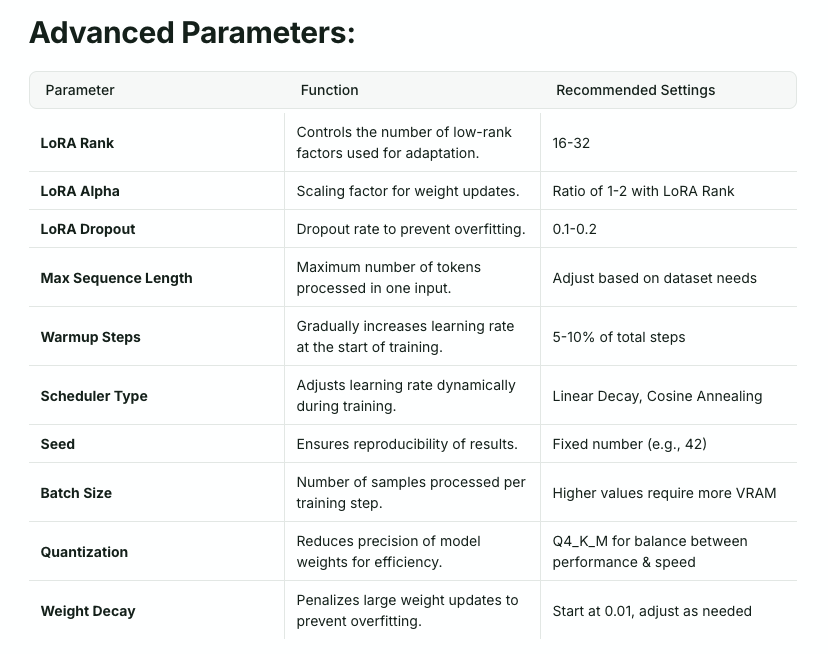

* Also from the unsloth docs are a great review of the Target Modules:

These components transform inputs for attention mechanisms:

1. **q_proj, k_proj, v_proj**
  * Handle queries, keys, and values.

2. **o_proj**
  * Integrates attention results into the model.

3. **gate_proj**
  * Manages flow in gated layers.

4. **up_proj, down_proj**
  * Adjust dimensionality for efficiency.


### Other LoRA Parameters to Consider
* These are important to remember when it comes to model accuracy, memory efficiency, speed and scalability:

1. **r (Rank of decomposition)**
  * Controls the finetuning process.
  * Suggested: 8, 16, 32, 64, or 128.

  * Higher
    * Better accuracy on hard tasks but increases memory and risk of overfitting.
  * Lower
    * Faster, memory-efficient but may reduce accuracy.

2. **lora_alpha (Scaling factor)**
  * Determines the learning strength.
  * Suggested: Equal to or double the rank (r).
  * Higher
    * Learns more but may overfit.
  * Lower
    * Slower to learn, more generalizable.

3. **lora_dropout (Default: 0)**
  * Dropout probability for regularization.
  * Higher
    * More regularization, slower training.
  * Lower (0)
    * Faster training, minimal impact on overfitting.

In [5]:
## Setup LoRa adapters
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing=True,
    random_state=42,
)

Unsloth 2025.3.17 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


# Load Dataset from Hugging Face
* This is the dataset: `HuggingFaceH4/deita-10k-v0-sft`
* data card: https://huggingface.co/datasets/HuggingFaceH4/deita-10k-v0-sft

In [6]:
## load dataset
dataset = load_dataset("HuggingFaceH4/deita-10k-v0-sft",
                       split=["train_sft", "test_sft"])

README.md:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

train_sft-00000-of-00001.parquet:   0%|          | 0.00/140M [00:00<?, ?B/s]

test_sft-00000-of-00001.parquet:   0%|          | 0.00/7.20M [00:00<?, ?B/s]

train_gen-00000-of-00001.parquet:   0%|          | 0.00/135M [00:00<?, ?B/s]

test_gen-00000-of-00001.parquet:   0%|          | 0.00/6.95M [00:00<?, ?B/s]

Generating train_sft split:   0%|          | 0/9500 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/9500 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [7]:
dataset

[Dataset({
     features: ['prompt', 'prompt_id', 'messages'],
     num_rows: 9500
 }),
 Dataset({
     features: ['prompt', 'prompt_id', 'messages'],
     num_rows: 500
 })]

# LoRA Hyperparameter Setup

In [8]:
## setup hyperparams
training_args=TrainingArguments(
    do_eval=True,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_ratio=0.1,
    num_train_epochs=1,
    learning_rate=2.0e-5,
    fp16=not torch.cuda.is_bf16_supported(), ## set fp16 to True if bfloat16 is not supported on current CUDA device and False if it is supported.
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=100,
    optim="adamw_8bit",
    lr_scheduler_type="cosine",
    seed=42,
    output_dir="./",

    )

Dataset mapping
* The dataset needs a formatting function for unsloth and we need to map it.

In [9]:
def formatting_func(example):
    # Assuming 'messages' contains the conversation
    messages = example['messages']

    # Construct the prompt
    prompt = "Human: " + messages[0]['content']

    # Construct the response (assuming the second message is the assistant's response)
    response = messages[1]['content'] if len(messages) > 1 else ""

    # Return a dictionary with the formatted text
    return {
        "text": f"{prompt}\n\nAssistant: {response}"
    }

# Apply the formatting_func to datasets
train_dataset = dataset[0].map(formatting_func)
eval_dataset = dataset[1].map(formatting_func)

Map:   0%|          | 0/9500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [10]:
# SFTTrainer initialization
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    max_seq_length=max_seq_length,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    },
    args=training_args,
)

Unsloth: Tokenizing ["text"] (num_proc=12):   0%|          | 0/9500 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=12):   0%|          | 0/500 [00:00<?, ? examples/s]

# Train LoRA Model

In [12]:
## trainer
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,500 | Num Epochs = 1 | Total steps = 593
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 50,003,968/7,000,000,000 (0.71% trained)


Step,Training Loss,Validation Loss
100,1.603900,1.672942
200,1.476000,1.578679
300,1.508600,1.562614
400,1.484700,1.553667
500,1.421800,1.534977


# DPO Training

In [13]:
## imports
from unsloth import FastLanguageModel
from trl import DPOTrainer
from peft import PeftModel
from transformers import AutoTokenizer, TrainingArguments
from datasets import load_dataset
import torch

In [14]:
## set parameters
max_seq_length=1024
dtype=None
load_in_4bit=True

# Load Checkpoint LoRA Model
* We load a LoRA checkpoint model for Direct Preference Optimization (DPO) to enable efficient fine-tuning on downstream tasks.
* Thus we can focus on updating a minimal number of parameters rather than retraining the entire model.

In [15]:
## load LoRA model checkpoint
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="/content/checkpoint-593",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

## ChatML tokenizer
tokenizer = AutoTokenizer.from_pretrained("philschmid/gemma-tokenizer-chatml",
                                          use_fast=True)

==((====))==  Unsloth 2025.3.17: Fast Gemma patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Load Argilla DPO Dataset
* We are going to use a different dataset for DPO fine tuning portion.
* Dataset: `argilla/dpo-mix-7k`
* Dataset card: https://huggingface.co/datasets/argilla/dpo-mix-7k
* This is a great blog about how to build a great DPO dataset: https://blog.gopenai.com/build-a-high-quality-dpo-dataset-596a07e574ec
## Why are we using a different dataset?
* The goal is to address specific shortcomings in a model or focus on particular aspects of its behavior, such as improving alignment with human preferences or handling specific types of prompts/responses.

In [16]:
## load dataset
dataset = load_dataset("argilla/dpo-mix-7k")
dataset

README.md:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.43M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6750 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/750 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['dataset', 'chosen', 'rejected', 'chosen_rating', 'rejected_rating'],
        num_rows: 6750
    })
    test: Dataset({
        features: ['dataset', 'chosen', 'rejected', 'chosen_rating', 'rejected_rating'],
        num_rows: 750
    })
})

In [17]:
## column names to list features
column_names = list(dataset['train'].features)
column_names

['dataset', 'chosen', 'rejected', 'chosen_rating', 'rejected_rating']

# Setup DPO Template for Training

In [18]:
def apply_dpo_template(example):
  if all(k in example.keys() for k in ("chosen", "rejected")):
    # For DPO, the inputs are triples of (prompt, chosen, rejected), where `chosen` and `rejected` are the final turn of a dialogue
    # We therefore need to extract the N-1 turns to form the prompt
    prompt_messages = example["chosen"][:-1]


    # Now we extract the final turn to define chosen/rejected responses
    chosen_messages = example["chosen"][-1:]
    rejected_messages = example["rejected"][-1:]
    example["text_chosen"] = tokenizer.apply_chat_template(chosen_messages, tokenize=False)
    example["text_rejected"] = tokenizer.apply_chat_template(rejected_messages, tokenize=False)
    example["text_prompt"] = tokenizer.apply_chat_template(prompt_messages, tokenize=False)
  return example


## map DPO function to dataset
dataset = dataset.map(apply_dpo_template,remove_columns=column_names,
          desc="Formatting comparisons with prompt template",)


for split in ["train", "test"]:
    dataset[split] = dataset[split].rename_columns(
        {"text_prompt": "prompt", "text_chosen": "chosen", "text_rejected": "rejected"}
    )


Formatting comparisons with prompt template:   0%|          | 0/6750 [00:00<?, ? examples/s]

Formatting comparisons with prompt template:   0%|          | 0/750 [00:00<?, ? examples/s]

In [19]:
## lets see dataset for training
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['chosen', 'rejected', 'prompt'],
        num_rows: 6750
    })
    test: Dataset({
        features: ['chosen', 'rejected', 'prompt'],
        num_rows: 750
    })
})


## DPO Hyperparameters
* These are pretty much the same as for LoRA

In [20]:
## setup DPO hyperparams
training_args=TrainingArguments(
    do_eval=True,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="epoch",
    per_device_train_batch_size=1, ## change from 4 --> 1
    per_device_eval_batch_size=16, ## changed from 4 --> 16
    gradient_accumulation_steps=1, ## changed from 4 --> 1
    warmup_ratio=0.1,
    num_train_epochs=1,
    learning_rate=5.0e-7,     # LoRA lr = 2.0e-5,
    fp16=not torch.cuda.is_bf16_supported(), ## set fp16 to True if bfloat16 is not supported on current CUDA device and False if it is supported.
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=100,
    optim="paged_adamw_8bit",  # LoRA optim --> "adamw_8bit",
    lr_scheduler_type="cosine",
    seed=42,
    output_dir="./gemma7b_DPO_model",

    )

## Setup PatchDPOTrainer
* Unsloth version of the hugging face DPOTrainer:
  * Faster training times
  * Reduced memory usage
  * Compatibility with the Hugging Face ecosystem

In [21]:
from unsloth import PatchDPOTrainer

## init trainer
PatchDPOTrainer()

Note about Beta:
* Experiment with different beta values to control the influence of the reference model.
* **A higher beta gives more weight to the reference models preferences.**

In [22]:
## setup trainer
trainer=DPOTrainer(
    model,
    ref_model = None,
    args= training_args,
    beta = 0.05, ## experiemnt with different values
    train_dataset = dataset['train'],
    eval_dataset = dataset['test'],
    tokenizer = tokenizer
)

Extracting prompt in train dataset (num_proc=12):   0%|          | 0/6750 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=12):   0%|          | 0/6750 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=12):   0%|          | 0/6750 [00:00<?, ? examples/s]

Extracting prompt in eval dataset (num_proc=12):   0%|          | 0/750 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=12):   0%|          | 0/750 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=12):   0%|          | 0/750 [00:00<?, ? examples/s]

In [23]:
## train the DPO model
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 6,750 | Num Epochs = 1 | Total steps = 6,750
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 50,003,968/7,000,000,000 (0.71% trained)


Step,Training Loss,Validation Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss,aux_loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 15.62 GiB. GPU 0 has a total capacity of 39.56 GiB of which 11.89 GiB is free. Process 2928 has 27.53 GiB memory in use. Of the allocated memory 25.40 GiB is allocated by PyTorch, and 1.60 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)